<a href="https://colab.research.google.com/github/eleubner02/01-Stat-Arb-Pairs-Trading/blob/feat%2Foos-validation/notebooks/pairs_trading_analysis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pairs Trading Strategy: Stat Arb

## Summary:

* Project: Cointegration-based Statistical Arbitrage on LUV–AAL (2020–2024)
* Method: OLS hedge ratio on log prices; residual z-score with shifted rolling stats; ENTRY=2.0, EXIT=0.5, z_window=60; time-stop=16 days; transaction costs 2 bps/leg on position changes.
* In‑Sample (2020–22): Sharpe: 1.51 | Annualized Return: 2.08% | Trades: 14  

* Out‑of‑Sample (2023–24): Sharpe: 1.09 | Annualized Return: 2.17% | Trades: 12  

* Full Sample (2020–24): Sharpe: 1.54 | Annualized Return: 2.49% | Max Drawdown: –1.32% | Trades: 30  

* Robustness: Sensitivity across ENTRY/EXIT, z_window, and time-stop variants. Chosen config balanced Sharpe and trade frequency.

# 1. Configuration and Imports

In [1]:
# !pip install yfinance

In [2]:
# Parameters
stockA, stockB = 'LUV', 'AAL'
START_DATE, END_DATE = '2020-01-01', '2025-01-01'

ENTRY, EXIT = 2.0, 0.5
Z_WINDOW = 60
TIME_STOP_DAYS = 16

BPS_PER_LEG = 0.0002
INITIAL_CAPITAL = 100000.0
NOTIONAL_LONG_LEG = 10000.0  # dollars on the A leg

# Imports
# Standard library
import math
from itertools import combinations
import os

# Third-party libraries
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

# 2. Data Load

In [3]:
prices = yf.download([stockA, stockB], start=START_DATE, end=END_DATE, progress=False)['Close']
prices = prices.dropna().sort_index()
assert set([stockA, stockB]).issubset(prices.columns)

/tmp/ipython-input-2067626206.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download([stockA, stockB], start=START_DATE, end=END_DATE, progress=False)['Close']


# 3. Hedge Ratio, Spread, and Stationarity Test

To construct a pairs trading strategy, we first need a **stationary spread** between two securities:

1. **OLS Regression (Hedge Ratio):**  
   We regress log-price of A on log-price of B:  
   
$$
\log(P_A) = a + b \cdot \log(P_B) + \epsilon
$$  
   - Here, $b$ is the hedge ratio (how many dollars of B to hold per dollar of A).  
   - The residual $\epsilon$ represents the spread.

2. **Spread Definition:**  
   Residuals from this regression (`spread = logA – (a + b·logB)`) measure *temporary deviations* from a long-run equilibrium.  
   If A and B are economically related (e.g., airlines exposed to the same fuel demand), we expect mean reversion of these residuals.

3. **ADF Test (Stationarity Check):**  
   The Augmented Dickey-Fuller (ADF) test formally asks:  
   - **H₀:** The series has a unit root (non-stationary).  
   - **H₁:** The series is stationary around a mean.  
   We want a **p-value < 0.05** to reject H₀ and conclude the spread is stationary, making it a candidate for mean-reverting trading logic.


In [4]:
# Align and log-transform

pxA = prices[stockA].dropna()
pxB = prices[stockB].dropna()
df = pd.concat([pxA, pxB], axis=1, keys=[stockA, stockB]).dropna()

logA = np.log(df[stockA])
logB = np.log(df[stockB])

# OLS: logA = a + b*logB

X = sm.add_constant(logB.values)
ols = sm.OLS(logA.values, X).fit()
a, b = ols.params[0], ols.params[1]

# Residual spread (stationary candidate)

spread = logA - (a + b*logB)

# 4. Z-Score Function

The z-score serves as our signal to trade. The z-score is a normalized measure, which coupled with thresholds, tells us when we are far enough from the mean spread to execute our strategy.

In [5]:
# z-score function. .shift(1) is crucial because it prevents lookahead bias by only focusing on data before a given date
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

z = zscore(spread, Z_WINDOW)
threshold = ENTRY

adf_p = adfuller(spread.dropna())[1]
cross_up = ((z.shift(1) <= threshold) & (z > threshold)).sum()
cross_dn = ((z.shift(1) >= -threshold) & (z < -threshold)).sum()

print(f"Hedge ratio b: {b:.3f}, intercept a: {a:.4f}")
print(f"ADF p-value on residual spread: {adf_p:.4f}")

Hedge ratio b: 0.842, intercept a: 1.2778
ADF p-value on residual spread: 0.0268


# 5. Final Backtest Function



**Description:**
This feature implements a vectorized backtesting engine to simulate the performance of the statistical arbitrage pairs trading strategy. It iterates through historical price data on a daily basis, executes trades based on z-score signals, and tracks the portfolio's mark-to-market value over time.

**Core Logic:**
The engine operates on a daily loop with the following logic:
1.  **Initialization:** The backtest begins with a predefined starting capital and a 'FLAT' (no-risk) position.
2.  **Signal Generation:** Each day, it calculates the z-score of the pair's spread. If the z-score crosses a predefined entry threshold (e.g., >2.0 or <-2.0), a trade signal is generated.
3.  **Trade Execution:** On a signal, if no position is currently held, the engine simulates a trade. It allocates a fixed amount of capital (e.g., $10,000) to both the long and short legs of the pair, calculates the number of shares, and updates the cash balance. The position state is updated to 'LONG' or 'SHORT'.
4.  **Position Closing:** If a position is open and the z-score reverts toward the mean (e.g., `abs(z-score) < 0.5`), the position is closed. All holdings are sold at the current market price, cash is updated, and the position is reset to 'FLAT'.
5.  **Daily Mark-to-Market:** At the end of every day, the engine calculates the total portfolio value by summing the current cash balance and the market value of any shares held. This daily value is stored to generate an equity curve.

We present the main function `backtest_pairs()` used for the reported results.
Simplified versions (`run_backtest`) appear later in Appendix A for parameter sweeps and robustness checks.

In [6]:
def backtest_pairs(prices_df, a, b,
                   entry=ENTRY, exit_=EXIT, z_window=Z_WINDOW,
                   time_stop_days=TIME_STOP_DAYS, use_time_stop=True,
                   initial_capital=INITIAL_CAPITAL, bps_per_leg=BPS_PER_LEG,
                   notional_long_leg=NOTIONAL_LONG_LEG,
                   stockA=stockA, stockB=stockB):
    """
    Generic backtester that works for either full‑sample or IS/OOS validation.
    - prices_df: DataFrame with two aligned price series [stockA, stockB]
    - a, b: hedge ratio intercept and slope (must be pre‑fit on chosen data)
    """

    # Log transform
    logA = np.log(prices_df[stockA])
    logB = np.log(prices_df[stockB])

    # Spread with passed coefficients
    spread_local = logA - (a + b * logB)

    # Z-score
    z_local = zscore(spread_local, z_window).dropna()
    df_local = prices_df.loc[z_local.index]

    # State vars
    equity = initial_capital
    pos = 0
    shares_A = shares_B = 0
    trade_pnl = 0.0
    holding_days = 0
    equity_list, dates_list, trades_log = [], [], []

    def pos_sizes_long(beta, pA, pB, notionalA):
        shA = math.floor(notionalA / pA)
        shB = -math.floor(beta * notionalA / pB)
        return shA, shB

    def pos_sizes_short(beta, pA, pB, notionalA):
        shA = -math.floor(notionalA / pA)
        shB = math.floor(beta * notionalA / pB)
        return shA, shB

    def trade_cost(shA, pA, shB, pB, bps):
        return bps * (abs(shA)*pA + abs(shB)*pB)

    dates = df_local.index
    for t in range(z_window, len(dates)):
        d = dates[t]
        pA_prev, pB_prev = df_local.iloc[t-1][stockA], df_local.iloc[t-1][stockB]
        pA, pB = df_local.iloc[t][stockA], df_local.iloc[t][stockB]

        # Accrue P&L
        if pos != 0:
            day_pnl = shares_A*(pA-pA_prev) + shares_B*(pB-pB_prev)
            equity += day_pnl
            trade_pnl += day_pnl
            holding_days += 1

        # Exit logic
        exit_signal = (pos != 0 and abs(z_local.iloc[t]) < exit_)
        time_stop_hit = (pos != 0 and use_time_stop and holding_days >= time_stop_days)
        if exit_signal or time_stop_hit:
            equity -= trade_cost(shares_A,pA,shares_B,pB,bps_per_leg)
            trades_log.append({
                'date': d, 'action': 'EXIT', 'pos': pos, 'z': float(z_local.iloc[t]),
                'pnl': trade_pnl, 'holding_days': holding_days,
                'shares_A': shares_A, 'shares_B': shares_B, 'price_A': pA, 'price_B': pB,
                'reason': 'TIME_STOP' if time_stop_hit and not exit_signal else (
                           'REVERT' if exit_signal and not time_stop_hit else 'REVERT+TIME_STOP')
            })
            pos, shares_A, shares_B, trade_pnl, holding_days = 0,0,0,0,0

        # Entry logic
        if pos == 0:
            if z_local.iloc[t] < -entry:
                shA, shB = pos_sizes_long(b,pA,pB,notional_long_leg)
                if shA!=0 and shB!=0:
                    equity -= trade_cost(shA,pA,shB,pB,bps_per_leg)
                    pos, shares_A, shares_B = 1,shA,shB
                    trades_log.append({'date': d,'action':'ENTER_LONG','pos':1,'z':float(z_local.iloc[t])})
            elif z_local.iloc[t] > entry:
                shA, shB = pos_sizes_short(b,pA,pB,notional_long_leg)
                if shA!=0 and shB!=0:
                    equity -= trade_cost(shA,pA,shB,pB,bps_per_leg)
                    pos, shares_A, shares_B = -1,shA,shB
                    trades_log.append({'date': d,'action':'ENTER_SHORT','pos':-1,'z':float(z_local.iloc[t])})

        equity_list.append(equity); dates_list.append(d)

    # Results
    trades_df = pd.DataFrame(trades_log)
    portfolio_df = pd.DataFrame({'Portfolio_Value':equity_list}, index=pd.DatetimeIndex(dates_list))
    portfolio_df['Daily_Return'] = portfolio_df['Portfolio_Value'].pct_change().dropna()

    daily = portfolio_df['Daily_Return']
    sharpe = float(np.sqrt(252)*daily.mean()/daily.std()) if len(daily) else np.nan
    cum_return = (1+daily).prod() - 1
    ann_return = (1+cum_return)**(252/len(daily)) - 1 if len(daily) else np.nan
    portfolio_df['Peak'] = portfolio_df['Portfolio_Value'].cummax()
    max_dd = float((portfolio_df['Portfolio_Value']/portfolio_df['Peak'] - 1).min())

    exits = trades_df[trades_df['action']=='EXIT']
    metrics = {
        'Sharpe':sharpe, 'AnnRet':ann_return, 'MaxDD':max_dd,
        'Trades':len(exits), 'AvgHoldDays':exits['holding_days'].mean() if not exits.empty else np.nan,
        'z_window': z_window # Add z_window to metrics
    }
    return metrics, trades_df, portfolio_df, z_local

# 6. Final Backtest with Chosen Parameters

**Next Steps:**
- Plot the `portfolio_value_history` to visualize the strategy's equity curve.
- Calculate key performance metrics (e.g., Sharpe Ratio, Total Return, Max Drawdown)

In [7]:
final_metrics, trades_df, portfolio_df, z_used = backtest_pairs(
    prices_df=prices, a=a, b=b,
    entry=ENTRY, exit_=EXIT, z_window=Z_WINDOW, time_stop_days=TIME_STOP_DAYS, use_time_stop=True
)
print(pd.Series(final_metrics))

Sharpe         1.540934
AnnRet         0.024919
MaxDD         -0.013193
Trades        30.000000
AvgHoldDays   11.733333
z_window      60.000000
dtype: float64


# 7. Plots

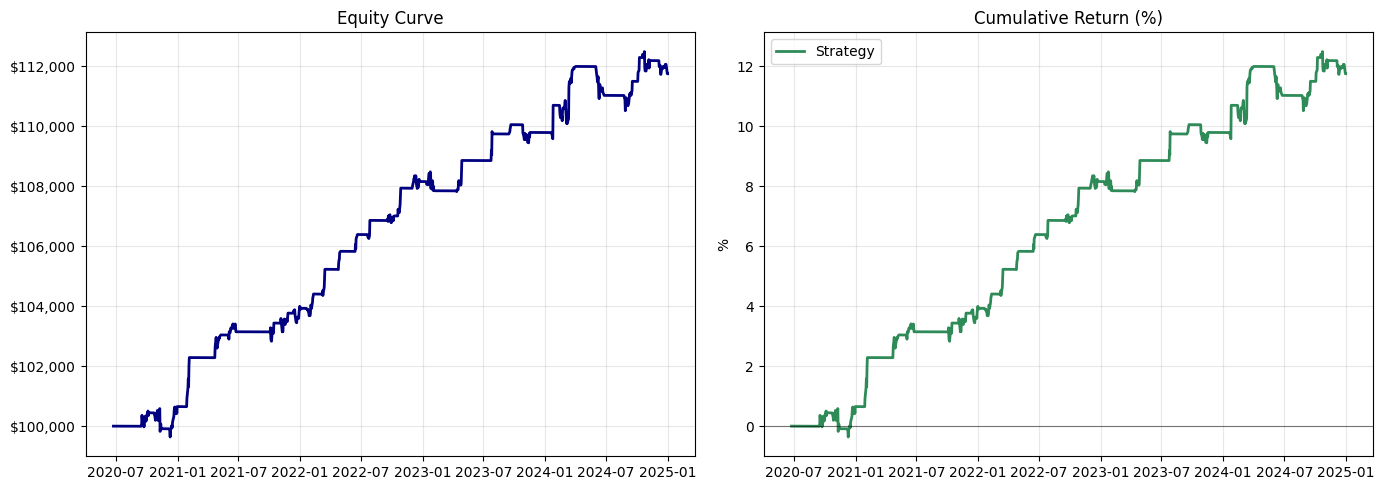

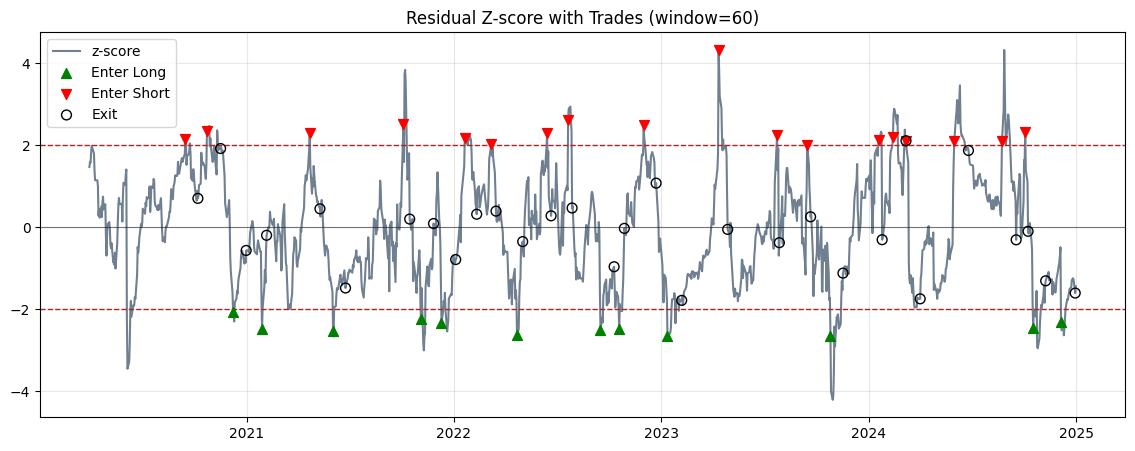

Artifacts saved → figures/equity_curve.png, figures/zscore_trades.png, trades.csv


In [8]:
# === Equity curve + Cumulative returns ===
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(portfolio_df.index, portfolio_df['Portfolio_Value'], color='navy', lw=2)
ax[0].set_title('Equity Curve', fontsize=12)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax[0].grid(True, alpha=0.3)

cum_ret = portfolio_df['Portfolio_Value'] / INITIAL_CAPITAL - 1.0
ax[1].plot(cum_ret.index, 100*cum_ret, color='seagreen', lw=2, label='Strategy')
ax[1].axhline(0, color='black', lw=0.8, alpha=0.5) # Changed lw to 0.8 for consistency
ax[1].set_title('Cumulative Return (%)', fontsize=12)
ax[1].set_ylabel('%')
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
# Create the figures directory if it doesn't exist
os.makedirs("figures", exist_ok=True)
fig.savefig("figures/equity_curve.png", dpi=150, bbox_inches="tight")
plt.show()

# === Z-score with trade markers ===
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(z_used.index, z_used.values, color='slategray', lw=1.5, label='z-score')
ax.axhline(ENTRY, color='firebrick', ls='--', lw=1)
ax.axhline(-ENTRY, color='firebrick', ls='--', lw=1)
ax.axhline(0, color='black', lw=0.8, alpha=0.5)

entries_long = trades_df[trades_df['action']=='ENTER_LONG']['date']
entries_short = trades_df[trades_df['action']=='ENTER_SHORT']['date']
exits = trades_df[trades_df['action']=='EXIT']['date']

ax.scatter(entries_long, z_used.loc[entries_long], marker='^', color='green', s=50, label='Enter Long', zorder=3)
ax.scatter(entries_short, z_used.loc[entries_short], marker='v', color='red', s=50, label='Enter Short', zorder=3)
ax.scatter(exits, z_used.loc[exits], marker='o', facecolors='none', edgecolors='black', s=50, label='Exit', zorder=3)

ax.set_title(f"Residual Z-score with Trades (window={final_metrics['z_window']})", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

fig.savefig("figures/zscore_trades.png", dpi=150, bbox_inches="tight")
plt.show()

# === Save Trades CSV ===
trades_df.to_csv("trades.csv", index=False)
print("Artifacts saved → figures/equity_curve.png, figures/zscore_trades.png, trades.csv")

# 8. Metrics Summary

* Results (2020–2024): Sharpe 1.54, unlevered annualized return 2.49%, max drawdown −1.32%.
* Trades: 30 completed, win rate 76.7%, average holding 11.7 days; 46.7% exits via time-stop.
* Costs: 2 bps/leg on entries/exits; applied only when positions change.
* Construction: Dollar-neutral sizing using OLS beta b≈0.842

In [9]:
pd.Series(final_metrics)

,0
Sharpe,1.540934
AnnRet,0.024919
MaxDD,-0.013193
Trades,30.000000
AvgHoldDays,11.733333
z_window,60.000000


# 9. Push Artifacts to Github

In [10]:
# Configure git inside Colab (first time per runtime)
!git config --global user.email "eleubner02@gmail.com"
!git config --global user.name "eleubner02"

# Move into repo folder (if not cloned yet, clone it first)
%cd /content
!rm -rf 01-Stat-Arb-Pairs-Trading   # clean if already exists
!git clone https://github.com/eleubner02/01-Stat-Arb-Pairs-Trading.git
%cd 01-Stat-Arb-Pairs-Trading

# Copy artifacts from Colab /content to repo folder
!mkdir -p figures
!cp /content/figures/*.png figures/
!cp /content/trades.csv .

# Add, commit, push
!git add figures/*.png trades.csv
!git commit -m "Add/Update backtest artifacts"

# Use the PAT for authentication
# Replace 'your_github_username' with your GitHub username and 'YOUR_PAT_SECRET_NAME' with the name you used in Colab Secrets for your PAT
from google.colab import userdata
github_pat = userdata.get('GITHUB_PAT') # Replace 'YOUR_PAT_SECRET_NAME' with the name of your secret

# Construct the remote URL with the PAT for authentication
# You might need to adjust the URL format based on your repository and how you set up the PAT
repo_url = f"https://{github_pat}@github.com/eleubner02/01-Stat-Arb-Pairs-Trading.git"
!git push {repo_url} main

/content
Cloning into '01-Stat-Arb-Pairs-Trading'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 130 (delta 8), reused 6 (delta 2), pack-reused 104 (from 1)
Receiving objects: 100% (130/130), 2.02 MiB | 4.21 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/01-Stat-Arb-Pairs-Trading
[main 5f85991] Add/Update backtest artifacts
 3 files changed, 61 insertions(+), 61 deletions(-)
 rewrite figures/equity_curve.png (70%)
 rewrite figures/zscore_trades.png (96%)
 rewrite trades.csv (100%)
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 223.22 KiB | 11.16 MiB/s, done.
Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/eleubner02/01-Stat-Arb-Pairs-Trading.git
  

# 0. Out-of-sample Validation

* IS (Training): 2020-2022
* OOS (Testing): 2023-2024

In [11]:
# 0-2 Data Load

train_data = yf.download([stockA, stockB], start='2020-01-01', end='2022-12-31', progress=False)['Close']
test_data = yf.download([stockA, stockB], start='2023-01-01', end='2024-12-31', progress=False)['Close']
train_data = train_data.dropna().sort_index()
test_data = test_data.dropna().sort_index()
assert set([stockA, stockB]).issubset(train_data.columns)
assert set([stockA, stockB]).issubset(test_data.columns)

# Revising Backtester

tdA = train_data[stockA].dropna()
tdB = train_data[stockB].dropna()
logA_train = np.log(tdA)
logB_train = np.log(tdB)

X = sm.add_constant(logB_train.values)
ols = sm.OLS(logA_train.values, X).fit()
a_train, b_train = ols.params
print(f"Fitted on train: a={a_train:.3f}, b={b_train:.3f}")

# In-sample run (2020-2022)
is_metrics, is_trades, is_port, _ = backtest_pairs(train_data, a_train, b_train)

# Out-of-sample run (2023-2024)
oos_metrics, oos_trades, oos_port, _ = backtest_pairs(test_data, a_train, b_train)

# Combine comparison
results = pd.DataFrame([is_metrics, oos_metrics], index=["In-Sample (2020-22)", "Out-of-Sample (2023-24)"])
print(results[['Sharpe','AnnRet','Trades']])

/tmp/ipython-input-3701941887.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  train_data = yf.download([stockA, stockB], start='2020-01-01', end='2022-12-31', progress=False)['Close']
/tmp/ipython-input-3701941887.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download([stockA, stockB], start='2023-01-01', end='2024-12-31', progress=False)['Close']


Fitted on train: a=1.708, b=0.714
                          Sharpe   AnnRet  Trades
In-Sample (2020-22)     1.511651 0.020798      14
Out-of-Sample (2023-24) 1.092036 0.021682      12
